<a href="https://colab.research.google.com/github/RafaelCerq/EstudosPython/blob/main/GansRedesAdvers%C3%A1riasGenerativas/Gans_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Deep Convolutional GANs

## Importação das bibliotecas


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.9.2'

## Carregamento e pré-processamento da base de dados

- MNIST é o nome da base de dados que possui os digitos escritos a mão




In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
X_treinamento.shape


(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_treinamento.shape

(60000,)

9


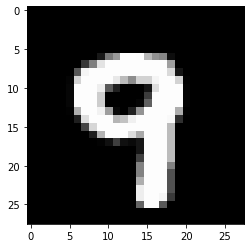

In [7]:
i = np.random.randint(0, 60000)
#print(i)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray');

Incluindo número de canais ao final do vetor x_treinamento

In [8]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [9]:
X_treinamento.shape

(60000, 28, 28, 1)

In [10]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

Aplicando normalização para treinamento da rede - Ao utilizar uma GAN é recomendado utilizar escalas entre -1 e 1. (127.5 é o valor que esta no meio de 255.0)

In [11]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [12]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

Dividir a base de dados de treinamento em batch. No caso, cada batch possui 256 imagens

In [13]:
buffer_size = 60000
batch_size = 256

In [14]:
buffer_size / batch_size

234.375

In [15]:
type(X_treinamento)

numpy.ndarray

Converte a base para o formato do tensorflow e dividir em batch

In [16]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [19]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()
  
  return network

In [20]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [21]:
# 100 -> 12544
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [22]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.17571919,  0.05708598,  1.3781433 , -0.41003314,  0.75118077,
         1.3427979 , -0.8544918 ,  0.08698763,  1.0753009 ,  0.29023215,
         0.8009731 , -0.5316599 ,  0.68613106, -0.23580031, -1.738215  ,
        -0.6052154 , -0.90829724,  0.3861921 , -0.01425858, -0.5527333 ,
         0.2657601 ,  0.8543374 , -0.56174886,  0.13173549, -0.11572605,
         1.4212601 ,  1.3521316 ,  0.770347  , -1.2928379 , -1.0398422 ,
         0.6528165 ,  2.3478138 , -1.4065105 , -0.08328447, -0.91593444,
         1.3862065 ,  0.66659534, -0.44422266,  1.060518  ,  1.3495251 ,
         0.63495827, -0.01372772, -1.5119002 , -0.6944546 , -0.10590616,
        -0.4766489 ,  0.01277073, -1.5522106 , -0.54817325,  1.5947852 ,
         1.2036034 , -0.30399352, -0.92888886, -0.71451056,  1.377109  ,
        -0.78625894,  1.6812912 ,  0.6814707 ,  0.7043254 , -0.604009  ,
         1.1475773 ,  0.20660667, -1.4279077 , -1.5552467 , -1.360298  ,
 

In [23]:
imagem_gerada = gerador(ruido, training = False)

In [24]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

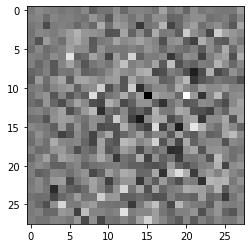

In [26]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');